In [62]:
import numpy as np
import datetime
import pandas as pd

import time
import pickle

from math import log10, floor

import matplotlib.pyplot as plt
import matplotlib

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner

[  18  132  784 2449 4582 4386 2955 2088 1061  768  565  382  270  169
  162  144  111  100   72   91  103  168  140  163  105  110  109  257
  371  416  185] 31
[  17  120  686 2025 3410 3140 2109 1504  777  561  424  279  197  127
  115  107   85   76   57   64   85  129  119  137   87   81   85  212
  298  324  185]
[   1   12   98  424 1172 1246  846  584  284  207  141  103   73   42
   47   37   26   24   15   27   18   39   21   26   18   29   24   45
   73   92    0] 31
0-19 23 [ 647  624  524  464  479  471  463  767  587  507  508  620  751  964
 1383 1965 2113 1883 1748 1876 2175 2273  843]
20-39 23 [2592 2378 2079 2141 2126 1109  753 1676 2927 3437 3079 2608 2347 2316
 2417 3127 3891 3573 3303 3402 4101 4379 1819]
40-59 23 [2125 1876 1409 1008  900  628  583 1321 1013  777  658  868 1189 1448
 1658 2002 2389 2145 2185 2590 3344 3554 1505]
60-79 23 [1295 1018  683  497  437  272  224  311  270  250  251  281  357  396
  469  452  519  532  556  857 1220 1319  574]
80+ 23 [10

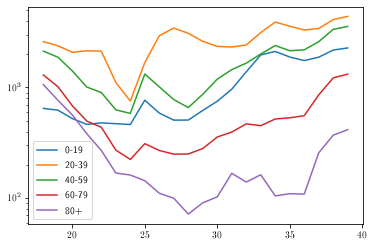

In [63]:
# Datasets
deaths,cases = {},{}
# cases starting KW10 (2nd half KW27) source sit-rep table , 1 week less than SurvStat
cases["100+"] = np.array([0,0,4,12,33,41,16,19,7,2,2,3,3,0,0,1,0]+[0,0,2,0,1,5,2,1,1,1,1,7,3,0])
cases["90-99"]= np.array([1,12,94,412,1139,1205,830,565,277,205,139,100,70,42,47,36,26]+[24,15,25,18,38,16,24,17,28,23,44,66,89,0])

# Via survstat starting KW10
cases["0-9"] = np.array([8,36,143,255,272,235,159,185,130,137,115,122,86,107,110,159,135,141,145,140,161,150,190,273,284,224,233,227,291,301,103])+np.array([10,57,168,249,292,235,163,153,119,105,111,81,112,100,123,176,140,124,115,138,151,199,285,408,380,351,318,325,350,381,137])
cases["10-19"] = np.array([21,103,253,378,429,301,236,188,135,125,117,108,119,102,119,192,145,104,100,150,191,250,364,544,575,478,431,497,514,566,225])+np.array([42,182,539,940,1076,858,569,401,263,257,181,153,162,162,111,240,167,138,148,192,248,365,544,740,874,830,766,827,1020,1025,378])
cases["20-29"] = np.array([70,323,1444,2270,2243,1728,1229,961,594,509,413,314,288,229,247,375,255,258,236,301,376,520,736,1163,1547,1327,1242,1276,1503,1560,566])+np.array([74,548,2005,2695,2484,1933,1297,992,683,518,387,349,317,220,243,393,323,315,226,307,410,508,606,833,1194,1213,1148,1233,1475,1425,572])
cases["30-39"] = np.array([260,259,295,380,424,510,697,940,853,933,930,1203,1282,505,69,534,2050,2638,2415,1749,1201,906,562,488,391,322,266,205,223,402,331])+np.array([65,546,1756,2387,2199,1651,981,763,462,418,349,275,239,155,194,374,299,226,202,251,360,382,513,643,759,711,647,688,900,992,350])
cases["40-49"] = np.array([86,570,1804,2327,2310,1673,1021,698,457,403,353,241,213,174,158,447,271,214,189,253,321,428,484,636,714,654,642,682,834,850,333])+np.array([100,744,2096,2923,2718,1919,1173,790,467,446,328,254,212,162,144,375,277,222,181,233,335,385,451,571,689,605,607,690,869,879,378])
cases["50-59"] = np.array([133,979,3093,4000,3701,2612,1555,989,601,518,373,250,239,150,147,315,263,185,172,207,291,350,416,471,558,536,549,667,889,981,404])+np.array([74,750,2599,3596,3669,2605,1563,1058,600,509,355,263,236,142,134,184,202,156,116,175,242,285,307,324,428,350,387,551,752,844,390])
cases["60-69"] = np.array([63,432,1600,2525,2781,1797,1083,675,407,330,239,175,168,107,89,120,108,110,93,109,153,150,202,192,238,244,246,337,491,525,229])+np.array([25,237,891,1649,1694,1116,659,504,265,208,144,124,108,60,51,69,65,62,62,70,85,85,120,110,119,130,127,224,291,301,139])
cases["70-79"] = np.array([11,144,622,1326,1413,1047,633,423,274,207,127,93,80,47,40,57,40,38,56,60,62,90,92,79,96,91,108,151,258,267,109])+np.array([23,112,571,1406,1786,1314,850,587,349,273,173,105,81,58,44,65,57,40,40,42,57,71,55,71,66,67,75,145,180,226,97])
cases["80+"] = np.array([18,132,784,2449,4582,4386,2955,2088,1061,768,565,382,270,169,162,144,111,100,72,91,103,168,140,163,105,110,109,257,371,416,185])



# build 90+, 80-89
cases["90+"] = cases["90-99"]+cases["100+"]
cases["80-89"] = cases["80+"]-cases["90+"]

print(cases["80+"],len(cases["80+"]))
print(cases["80-89"])
print(cases["90+"],len(cases["90+"]))

for k,v in cases.items():
    cases[k] = v[8:]

age_brackets = ["0-19","20-39","40-59","60-79","80+"]
ab = age_brackets 

cases_by_ab = {}
cases_by_ab[ab[0]] = cases["0-9"]+cases["10-19"]
cases_by_ab[ab[1]] = cases["20-29"]+cases["30-39"]
cases_by_ab[ab[2]] = cases["40-49"]+cases["50-59"]
cases_by_ab[ab[3]] = cases["60-69"]+cases["70-79"]
cases_by_ab[ab[4]] = cases["80+"]

    
for k,c in cases_by_ab.items():
    cases_by_ab[k] = cases_by_ab[k][:-1]
    print(k,len(c),c)


for k,v in cases_by_ab.items():
    plt.semilogy(range(18,40),v,label=k)
plt.legend()



23
0-9 23 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10-19 23 [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]
20-29 23 [6, 7, 7, 8, 9, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10]
30-39 23 [12, 15, 19, 19, 20, 20, 21, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 25, 25, 26, 26]
40-49 23 [44, 48, 54, 57, 63, 67, 68, 69, 69, 72, 75, 76, 76, 78, 79, 79, 79, 81, 81, 81, 82, 82, 83]
50-59 23 [186, 228, 256, 272, 282, 290, 299, 307, 312, 317, 319, 322, 322, 326, 327, 329, 330, 332, 336, 340, 344, 347, 348]
60-69 23 [526, 609, 681, 742, 775, 802, 821, 835, 848, 857, 865, 874, 877, 881, 888, 891, 893, 895, 901, 908, 911, 914, 923]
70-79 23 [1386, 1547, 1690, 1794, 1859, 1910, 1952, 1980, 2003, 2019, 2033, 2044, 2049, 2052, 2060, 2071, 2080, 2087, 2090, 2099, 2110, 2120, 2136]
80-89 23 [2687, 3101, 3404, 3595, 3726, 3813, 3896, 3922, 3954, 3982, 4001, 4010, 4022, 4033, 4045, 4065, 4082, 4101, 4109, 4115, 4124, 4137, 4158]
90-

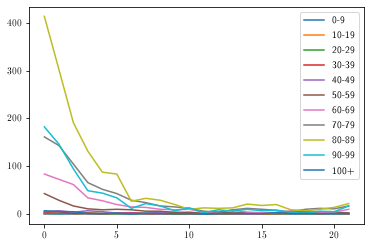

In [56]:
deaths_keys = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99","100+"]
deaths[40] = [   1,   1,  10,  26,  83, 348, 923,2136,4158,1718,  52] # Sitreport Di 30.09.2020
deaths[39] = [   1,   1,  10,  26,  82, 347, 914,2120,4137,1702,  52] # Sitreport Di 22.09.2020
deaths[38] = [   1,   1,  10,  25,  82, 344, 911,2110,4124,1698,  52] # Sitreport Di 15.09.2020
deaths[37] = [   1,   1,  10,  25,  81, 340, 908,2099,4115,1693,  52] # Sitreport Di 08.09.2020
deaths[36] = [   1,   1,  10,  24,  81, 336, 901,2090,4109,1692,  52] # Sitreport Di 01.09.2020

deaths[35] = [   1,   1,  10,  23,  81, 332, 895,2087,4101,1689,  52] # Sitreport Di 25.08.2020
deaths[34] = [   1,   1,  10,  23,  79, 330, 893,2080,4082,1682,  50] # Sitreport Di 18.08.2020
deaths[33] = [   1,   2,  10,  23,  79, 329, 891,2071,4065,1676,  50] # Sitreport Di 11.08.2020
deaths[32] = [   1,   2,   9,  23,  79, 327, 888,2060,4045,1667,  50] # Sitreport Di 04.08.2020

deaths[31] = [   1,   2,   9,  23,  78, 326, 881,2052,4033,1662,  50] # Sitreport Di 28.07.2020
deaths[30] = [   1,   2,   9,  23,  76, 322, 877,2049,4022,1654,  50] # Sitreport Di 21.07.2020
deaths[29] = [   1,   2,   9,  23,  76, 322, 874,2044,4010,1652,  51] # Sitreport Di 14.07.2020
deaths[28] = [   1,   2,   9,  23,  75, 319, 865,2033,4001,1640,  51] # Sitreport Di 07.07.2020

deaths[27] = [   1,   2,  10,  23,  72, 317, 857,2019,3982,1634,  51] # Sitreport Di 30.06.2020
deaths[26] = [   1,   2,   9,  23,  69, 312, 848,2003,3954,1618,  51] # Sitreport Di 23.06.2020
deaths[25] = [   1,   2,   9,  23,  69, 307, 835,1980,3922,1597,  50] # Sitreport Di 16.06.2020
deaths[24] = [   1,   2,   9,  21,  68, 299, 821,1952,3896,1586,  51] # Sitreport Di 09.06.2020
deaths[23] = [   1,   2,   9,  20,  67, 290, 802,1910,3813,1553,  50] # Sitreport Di 02.06.2020

deaths[22] = [   1,   2,   9,  20,  63, 282, 775,1859,3726,1510,  50] # Sitreport Di 26.05.2020
deaths[21] = [   1,   2,   8,  19,  57, 272, 742,1794,3595,1462,  50] # Sitreport Di 19.05.2020
deaths[20] = [   1,   2,   7,  19,  54, 256, 681,1690,3404,1368,  46] # Sitreport Di 12.05.2020
deaths[19] = [   1,   1,   7,  15,  48, 228, 609,1547,3101,1222,  42] # Sitreport Di 06.05.2020

deaths[18] = [   1,   1,   6,  12,  44, 186, 526,1386,2687,1040,  36] # Sitreport Di 28.04.2020

#deaths[19] = [   1,   1,   6,  12,  44, 186, 526,1386,2687,1040,  36] # Sitreport Di 21.04.2020

print(len(deaths))

deaths_by_age = {}
dkws = [x for x in deaths.keys()]
for i,dk in enumerate(deaths_keys):
    a = []
    for j,w in enumerate(range(min(dkws),max(dkws)+1)):
        a.append(deaths[w][i])
    print(dk,len(a),a)
    deaths_by_age[dk] = np.diff(np.array(a))

for k,v in deaths_by_age.items():
    plt.plot(v,label=k)
plt.legend()

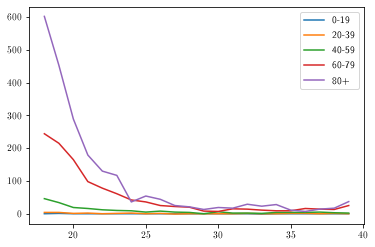

In [64]:
deaths_by_ab = {}
deaths_by_ab[ab[0]] = deaths_by_age["0-9"]+deaths_by_age["10-19"]
deaths_by_ab[ab[1]] = deaths_by_age["20-29"]+deaths_by_age["30-39"]
deaths_by_ab[ab[2]] = deaths_by_age["40-49"]+deaths_by_age["50-59"]
deaths_by_ab[ab[3]] = deaths_by_age["60-69"]+deaths_by_age["70-79"]
deaths_by_ab[ab[4]] = deaths_by_age["80-89"]+deaths_by_age["90-99"]+deaths_by_age["100+"]

deaths_by_age["90+"] = deaths_by_age["90-99"]+deaths_by_age["100+"]

for k,v in deaths_by_ab.items():
    plt.plot(range(min(dkws),max(dkws)),v,label=k)
plt.legend()

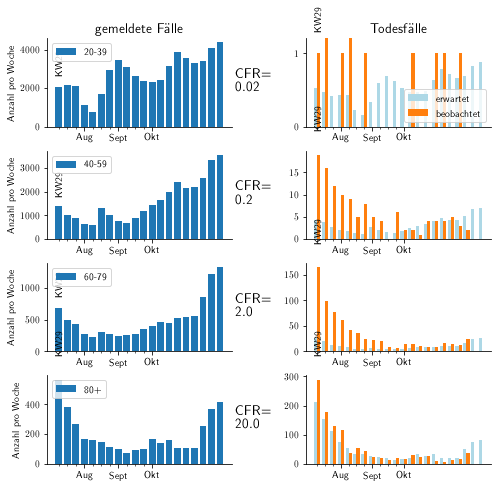

In [58]:
fig = plt.figure(figsize=(7,6.5))
fig.subplots_adjust(wspace=0.4,hspace=0.27,left=0.1,right=0.98,top=0.95,bottom=0.04)

gs = fig.add_gridspec(4, 2)

cfr = {"0-19":0.01,"20-39":0.0002,"40-59":0.002,"60-79":0.02,"80+":0.2}

for i,ab in enumerate(age_brackets[1:]):
    ax = fig.add_subplot(gs[i,0])
    bx = fig.add_subplot(gs[i,1])
    
    ax.text(28.7,cases_by_ab[ab][2]*1.3,"KW29",rotation=90,size=10)
    bx.text(28.7,max(deaths_by_ab[ab][2],cases_by_ab[ab][2]*cfr[ab])*1.3,"KW29",rotation=90,size=10)
    
    ax.bar(np.arange(len(cases_by_ab[ab])-2)+29,cases_by_ab[ab][2:],width=.8,label=ab,color="tab:blue")
    bx.bar(np.arange(len(cases_by_ab[ab]))-.2+29,cases_by_ab[ab][:]*cfr[ab],width=.4,color="lightblue",label="erwartet")
    bx.bar(np.arange(len(deaths_by_ab[ab])-2)+.2+29,deaths_by_ab[ab][2:],width=.4,color="tab:orange",label="beobachtet")
        
    if i == 0:
        bx.set_ylim([0,1.2])
        bx.set_yticks([0,1])
    ax.text(1.015,0.4,f"CFR=\n{cfr[ab]*100}%",transform=ax.transAxes,rotation=0,size=14)
  #  ax.arrow(1.05,0.1,.1,.0,transform=ax.transAxes)
    
    ax.legend(loc="upper left")
    if i == 0:
        bx.legend(loc="lower right")
        ax.set_title("gemeldete Fälle",size=14)
        bx.set_title("Todesfälle",size=14)
    ax.set_ylabel("Anzahl pro Woche")
    
    for tx in [ax,bx]:
        prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
     #   if prec < 2.0 and prec >= 0:
      #      tx.yaxis.set_major_formatter(
       #         matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        #    )
#    tx.set_xticks([datetime.date(2020,x,y) for x,y in [(3,1),(3,15),(4,1)]])
 #   tx.set_xticklabels(["",datetime.date(2020,3,15),""])
#    tx.set_xlim([ts[15],ts[l+1]])
        
        tx.spines['top'].set_visible(False)
        tx.spines['right'].set_visible(False)
        
        tx.set_xticks([32,36,40])
     #   tx.set_xticks([25,30,35,40],minor=True)
        tx.set_xticks(range(29,41),minor=True)
        tx.set_xticklabels(["Aug","Sept","Okt"])
    
   # bx.set_xticks([32,36,40])
     #   tx.set_xticks([25,30,35,40],minor=True)
    #bx.set_xticks(range(28,41),minor=True)
    #bx.set_xticklabels(["Aug","Sept","Okt"])

    #  tx.set_xticklabels([25,30,35,40],minor=True)
       #     tx.set_xticklabels(["","","",""])
 #   tx.set_xticks([28,32,36,40])

fig.savefig("AgeCfrEstimatedDeaths.pdf")

[474. 295. 220. 189.  89.  95.  78.  51.  45.  21.  32.  34.  46.  35.
  41.  25.  28.  33.  34.  64.]
[7720 6664 5260 4492 4212 2649 2185 4219 4908 5071 4568 4468 4747 5292
 6067 7709 9017 8243 7901 8982]


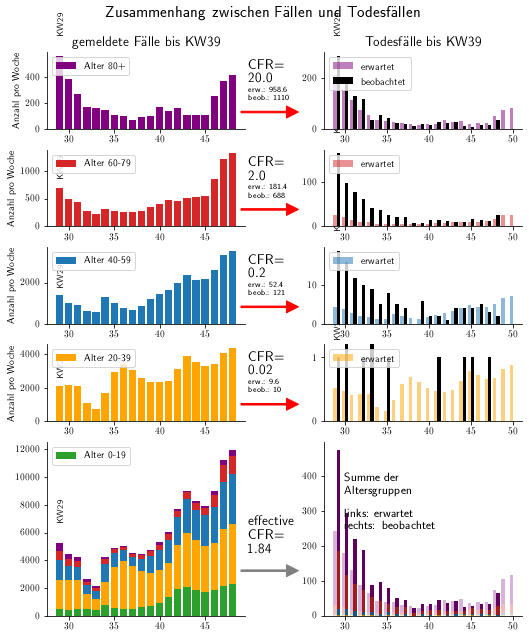

In [57]:
fig = plt.figure(figsize=(7.5,9))
fig.subplots_adjust(wspace=0.4,hspace=0.27,left=0.1,right=0.98,top=0.91,bottom=0.04)

#ts = pd.date_range(datetime.date(2020,2,1),periods=120,freq='D')
#pts = pd.date_range(datetime.date(2020,2,1)+datetime.timedelta(days=30),periods=31,freq='D')

gs = fig.add_gridspec(6, 2)

cfr = {"0-19":0.01,"20-39":0.0002,"40-59":0.002,"60-79":0.02,"80+":0.20}

cx = fig.add_subplot(gs[4:,0])
dx = fig.add_subplot(gs[4:,1])
txs = [cx,dx]

l = len(cases_by_ab["80+"])
last_c = np.zeros(l)
last_cd = np.zeros(l)
last_d = np.zeros(l)

last_c = cases_by_ab["0-19"].copy()
#last_d = deaths_by_ab["0-19"]

cx.bar(np.arange(len(cases_by_ab["0-19"])-2)+29,last_c[2:],bottom=0,width=.8,label="Alter 0-19",color="tab:green")    

color=["orange","tab:blue","tab:red","purple"]
for i,ab in enumerate(age_brackets[1:]):
    ax = fig.add_subplot(gs[3-i,0])
    bx = fig.add_subplot(gs[3-i,1])
    txs += [ax,bx]
    
    ax.text(28.7,cases_by_ab[ab][2]*1.3,"KW29",rotation=90,size=9)
    bx.text(28.7,max(deaths_by_ab[ab][2],cases_by_ab[ab][0]*cfr[ab])*1.3,"KW29",rotation=90,size=9)
    
    ax.bar(np.arange(len(cases_by_ab[ab])-2)+29,cases_by_ab[ab][2:],width=.8,label="Alter "+ab,color=color[i])#,color="tab:blue")
    bx.bar(np.arange(len(cases_by_ab[ab]))-.2+29,cases_by_ab[ab][:]*cfr[ab],width=.4,label="erwartet",color=color[i],alpha=.5)
    l = None
    if i == 3:
        l = "beobachtet"
    bx.bar(np.arange(len(deaths_by_ab[ab])-2)+.2+29,deaths_by_ab[ab][2:],width=.4,color="black",label=l)
    
    c = color[i]
    cx.bar(np.arange(len(cases_by_ab[ab])-2)+29,cases_by_ab[ab][2:],bottom=last_c[2:],width=.8,color=c)
    dx.bar(np.arange(len(cases_by_ab[ab]))-.2+29,cases_by_ab[ab][:]*cfr[ab],bottom=last_cd,width=.4,color=c,label="erwartet",alpha=.3)
    dx.bar(np.arange(len(deaths_by_ab[ab])-2)+.2+29,deaths_by_ab[ab][2:],bottom=last_d[2:],width=.4,color=c,label="beobachtet")
        
    last_c += cases_by_ab[ab]
    last_cd += cases_by_ab[ab]*cfr[ab]
    last_d += deaths_by_ab[ab]
    
    if i == 3:
        cx.text(28.7,max(last_c[2],last_c[2])*1.3,"KW29",rotation=90,size=9)
        dx.text(28.7,max(last_cd[2],last_d[2])*1.3,"KW29",rotation=90,size=9)
    
    if i == 0:
        bx.set_ylim([0,1.2])
        bx.set_yticks([0,1])
    ax.text(1.015,0.6,f"CFR=\n{cfr[ab]*100}%",transform=ax.transAxes,rotation=0,size=14)
    erw = np.sum(cases_by_ab[ab][:-3])*cfr[ab]
    ax.text(1.015,0.38,"erw.: %.1f\nbeob.: %d"%(erw,np.sum(deaths_by_ab[ab][2:])),transform=ax.transAxes,size=8)

    ax.annotate("",xy=(1.27,.22),xytext=(.98,.22),xycoords='axes fraction', arrowprops=dict( color='red',width=1.5))
    
    ax.legend(loc="upper left")
    
    bx.legend(loc="upper left")
        
    if i == 3:
        ax.set_title("gemeldete Fälle bis KW39",size=14)
        bx.set_title("Todesfälle bis KW39",size=14)
    ax.set_ylabel("Anzahl pro Woche")

cx.legend()
dx.text(.1,.7,"Summe der\nAltersgruppen",transform=dx.transAxes,size=12)
dx.text(.1,.5,"links: erwartet\nrechts: beobachtet",transform=dx.transAxes,size=12)
fig.suptitle("Zusammenhang zwischen Fällen und Todesfällen",size=16)

print(last_d[2:])
print(last_c[:-2])

s = "%.2f"%(100*np.mean(last_d[2:]/last_c[:-2]))
cx.text(1.015,0.36,f"effective\nCFR=\n~"+s+"%",transform=cx.transAxes,rotation=0,size=14)
cx.annotate("",xy=(1.27,.26),xytext=(.98,.26),xycoords='axes fraction', arrowprops=dict( color='grey',width=1.5))

dx.bar(np.arange(len(cases_by_ab[ab])-2)+.2+29,last_d[2:],width=.4,color="black",label="beobachtet",alpha=0.25)

for tx in txs:
        
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        
 #   tx.set_xticks([32,36,40])
 #   tx.set_xticks(range(29,41),minor=True)
 #   tx.set_xticklabels(["Aug","Sept","Okt"])
    
fig.savefig("AgeCfrEstimatedDeathsStack.pdf")
fig.savefig("AgeCfrEstimatedDeathsStack.png",dpi=300)

13
[21. 32. 34. 46. 35. 41. 25. 28. 33. 34. 64.]
[2693 2412 3014 3926 4810 6015 7918 9566 8774 8568 9707]


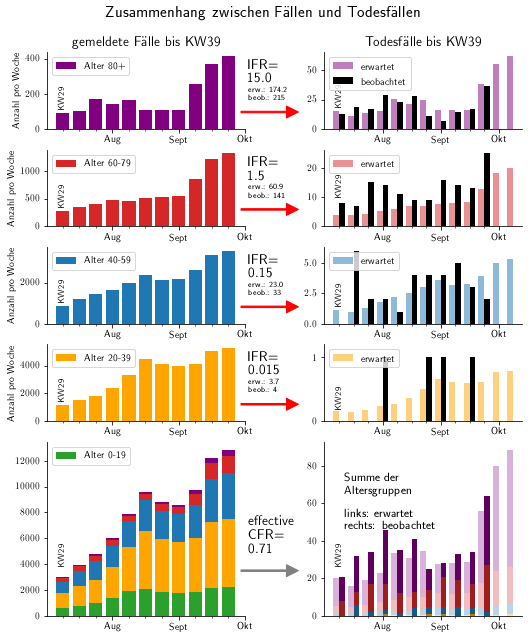

In [23]:
fig = plt.figure(figsize=(7.5,9))
fig.subplots_adjust(wspace=0.4,hspace=0.27,left=0.1,right=0.98,top=0.91,bottom=0.04)

ts = pd.date_range(datetime.date(2020,2,1),periods=120,freq='D')
pts = pd.date_range(datetime.date(2020,2,1)+datetime.timedelta(days=30),periods=31,freq='D')

gs = fig.add_gridspec(6, 2)

cfr = {"0-19":0.000015,"20-39":0.00015,"40-59":0.0015,"60-79":0.015,"80+":0.15}

cx = fig.add_subplot(gs[4:,0])
dx = fig.add_subplot(gs[4:,1])
txs = [cx,dx]

print(len(cases_by_ab["80+"]))
last_c = np.zeros(13)
last_cd = np.zeros(13)
last_d = np.zeros(13)

last_c = cases_by_ab["0-19"].copy()
#last_d = deaths_by_ab["0-19"]

cx.bar(np.arange(len(cases_by_ab["0-19"])-2)+29,last_c[2:],bottom=0,width=.8,label="Alter 0-19",color="tab:green")    

color=["orange","tab:blue","tab:red","purple"]
for i,ab in enumerate(age_brackets[1:]):
    ax = fig.add_subplot(gs[3-i,0])
    bx = fig.add_subplot(gs[3-i,1])
    txs += [ax,bx]
    
    ax.text(28.7,cases_by_ab[ab][2]*1.3,"KW29",rotation=90,size=9)
    bx.text(28.7,max(deaths_by_ab[ab][2],cases_by_ab[ab][0]*cfr[ab])*1.3,"KW29",rotation=90,size=9)
    
    ax.bar(np.arange(len(cases_by_ab[ab])-2)+29,cases_by_ab[ab][2:],width=.8,label="Alter "+ab,color=color[i])#,color="tab:blue")
    bx.bar(np.arange(len(cases_by_ab[ab]))-.2+29,cases_by_ab[ab][:]*cfr[ab],width=.4,label="erwartet",color=color[i],alpha=.5)
    l = None
    if i == 3:
        l = "beobachtet"
    bx.bar(np.arange(len(deaths_by_ab[ab])-2)+.2+29,deaths_by_ab[ab][2:],width=.4,color="black",label=l)
    
    c = color[i]
    cx.bar(np.arange(len(cases_by_ab[ab])-2)+29,cases_by_ab[ab][2:],bottom=last_c[2:],width=.8,color=c)
    dx.bar(np.arange(len(cases_by_ab[ab]))-.2+29,cases_by_ab[ab][:]*cfr[ab],bottom=last_cd,width=.4,color=c,label="erwartet",alpha=.3)
    dx.bar(np.arange(len(deaths_by_ab[ab])-2)+.2+29,deaths_by_ab[ab][2:],bottom=last_d[2:],width=.4,color=c,label="beobachtet")
        
    last_c += cases_by_ab[ab]
    last_cd += cases_by_ab[ab]*cfr[ab]
    last_d += deaths_by_ab[ab]
    
    if i == 3:
        cx.text(28.7,max(last_c[2],last_c[2])*1.3,"KW29",rotation=90,size=9)
        dx.text(28.7,max(last_cd[2],last_d[2])*1.3,"KW29",rotation=90,size=9)
    
    if i == 0:
        bx.set_ylim([0,1.2])
        bx.set_yticks([0,1])
    ax.text(1.015,0.6,f"IFR=\n{cfr[ab]*100}%",transform=ax.transAxes,rotation=0,size=14)
    erw = np.sum(cases_by_ab[ab][:-3])*cfr[ab]
    ax.text(1.015,0.38,"erw.: %.1f\nbeob.: %d"%(erw,np.sum(deaths_by_ab[ab][2:])),transform=ax.transAxes,size=8)
    ax.annotate("",xy=(1.27,.22),xytext=(.98,.22),xycoords='axes fraction', arrowprops=dict( color='red',width=1.5))
    
    ax.legend(loc="upper left")
    bx.legend(loc="upper left")
        
    if i == 3:
        ax.set_title("gemeldete Fälle bis KW39",size=14)
        bx.set_title("Todesfälle bis KW39",size=14)
    ax.set_ylabel("Anzahl pro Woche")

cx.legend()
dx.text(.1,.7,"Summe der\nAltersgruppen",transform=dx.transAxes,size=12)
dx.text(.1,.5,"links: erwartet\nrechts: beobachtet",transform=dx.transAxes,size=12)
fig.suptitle("Zusammenhang zwischen Fällen und Todesfällen",size=16)

print(last_d[2:])
print(last_c[:-2])

s = "%.2f"%(100*np.mean(last_d[2:]/last_c[:-2]))
cx.text(1.015,0.36,f"effective\nCFR=\n~"+s+"%",transform=cx.transAxes,rotation=0,size=14)
cx.annotate("",xy=(1.27,.26),xytext=(.98,.26),xycoords='axes fraction', arrowprops=dict( color='grey',width=1.5))

dx.bar(np.arange(len(deaths_by_age[ag])-2)+.2+29,last_d[2:],width=.4,color="black",label="beobachtet",alpha=0.25)

for tx in txs:
        
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        
    tx.set_xticks([32,36,40])
    tx.set_xticks(range(29,41),minor=True)
    tx.set_xticklabels(["Aug","Sept","Okt"])
    
fig.savefig("AgeIFRestimatedDeathsStack.pdf")
fig.savefig("AgeIFRestimatedDeathsStack.png",dpi=300)

13
[21. 32. 34. 46. 35. 41. 25. 28. 33. 34. 64.]
[2693 2412 3014 3926 4810 6015 7918 9566 8774 8568 9707]


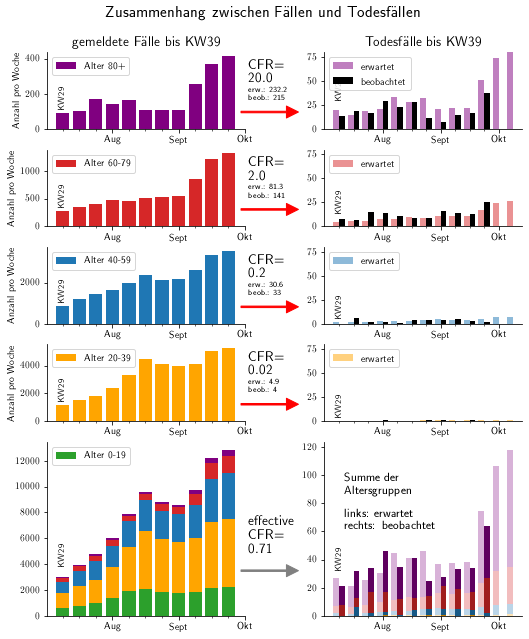

In [19]:
fig = plt.figure(figsize=(7.5,9))
fig.subplots_adjust(wspace=0.4,hspace=0.27,left=0.1,right=0.98,top=0.91,bottom=0.04)

ts = pd.date_range(datetime.date(2020,2,1),periods=120,freq='D')
pts = pd.date_range(datetime.date(2020,2,1)+datetime.timedelta(days=30),periods=31,freq='D')

gs = fig.add_gridspec(6, 2)

cfr = {"0-19":0.01,"20-39":0.0002,"40-59":0.002,"60-79":0.02,"80+":0.20}

cx = fig.add_subplot(gs[4:,0])
dx = fig.add_subplot(gs[4:,1])
txs = [cx,dx]

print(len(cases_by_ab["80+"]))
last_c = np.zeros(13)
last_cd = np.zeros(13)
last_d = np.zeros(13)

last_c = cases_by_ab["0-19"].copy()
#last_d = deaths_by_ab["0-19"]

cx.bar(np.arange(len(cases_by_ab["0-19"])-2)+29,last_c[2:],bottom=0,width=.8,label="Alter 0-19",color="tab:green")    

color=["orange","tab:blue","tab:red","purple"]
for i,ab in enumerate(age_brackets[1:]):
    ax = fig.add_subplot(gs[3-i,0])
    bx = fig.add_subplot(gs[3-i,1])
    txs += [ax,bx]
    
    ax.text(28.7,cases_by_ab[ab][2]*1.3,"KW29",rotation=90,size=9)
    bx.text(28.7,max(deaths_by_ab[ab][2],cases_by_ab[ab][0]*cfr[ab])*1.3+5,"KW29",rotation=90,size=9)
    
    ax.bar(np.arange(len(cases_by_ab[ab])-2)+29,cases_by_ab[ab][2:],width=.8,label="Alter "+ab,color=color[i])#,color="tab:blue")
    bx.bar(np.arange(len(cases_by_ab[ab]))-.2+29,cases_by_ab[ab][:]*cfr[ab],width=.4,label="erwartet",color=color[i],alpha=.5)
    l = None
    if i == 3:
        l = "beobachtet"
    bx.bar(np.arange(len(deaths_by_ab[ab])-2)+.2+29,deaths_by_ab[ab][2:],width=.4,color="black",label=l)
    
    c = color[i]
    cx.bar(np.arange(len(cases_by_ab[ab])-2)+29,cases_by_ab[ab][2:],bottom=last_c[2:],width=.8,color=c)
    dx.bar(np.arange(len(cases_by_ab[ab]))-.2+29,cases_by_ab[ab][:]*cfr[ab],bottom=last_cd,width=.4,color=c,label="erwartet",alpha=.3)
    dx.bar(np.arange(len(deaths_by_ab[ab])-2)+.2+29,deaths_by_ab[ab][2:],bottom=last_d[2:],width=.4,color=c,label="beobachtet")
        
    last_c += cases_by_ab[ab]
    last_cd += cases_by_ab[ab]*cfr[ab]
    last_d += deaths_by_ab[ab]
    
    if i == 3:
        cx.text(28.7,max(last_c[2],last_c[2])*1.3,"KW29",rotation=90,size=9)
        dx.text(28.7,max(last_cd[2],last_d[2])*1.3,"KW29",rotation=90,size=9)
    
   # if i == 0:
    #    bx.set_ylim([0,1.2])
    #    bx.set_yticks([0,1])
    ax.text(1.015,0.6,f"CFR=\n{cfr[ab]*100}%",transform=ax.transAxes,rotation=0,size=14)
    erw = np.sum(cases_by_ab[ab][:-3])*cfr[ab]
    ax.text(1.015,0.38,"erw.: %.1f\nbeob.: %d"%(erw,np.sum(deaths_by_ab[ab][2:])),transform=ax.transAxes,size=8)
    ax.annotate("",xy=(1.27,.22),xytext=(.98,.22),xycoords='axes fraction', arrowprops=dict( color='red',width=1.5))
    
    ax.legend(loc="upper left")
    bx.legend(loc="upper left")
        
    if i == 3:
        ax.set_title("gemeldete Fälle bis KW39",size=14)
        bx.set_title("Todesfälle bis KW39",size=14)
    ax.set_ylabel("Anzahl pro Woche")
    
    bx.set_ylim([0,80])
    bx.set_yticks([0,25,50,75])

cx.legend()
dx.text(.1,.7,"Summe der\nAltersgruppen",transform=dx.transAxes,size=12)
dx.text(.1,.5,"links: erwartet\nrechts: beobachtet",transform=dx.transAxes,size=12)
fig.suptitle("Zusammenhang zwischen Fällen und Todesfällen",size=16)

print(last_d[2:])
print(last_c[:-2])

s = "%.2f"%(100*np.mean(last_d[2:]/last_c[:-2]))
cx.text(1.015,0.36,f"effective\nCFR=\n~"+s+"%",transform=cx.transAxes,rotation=0,size=14)
cx.annotate("",xy=(1.27,.26),xytext=(.98,.26),xycoords='axes fraction', arrowprops=dict( color='grey',width=1.5))

# Darken deaths in lower right graph.
dx.bar(np.arange(len(deaths_by_age[ag])-2)+.2+29,last_d[2:],width=.4,color="black",label="beobachtet",alpha=0.25)


for tx in txs:
        
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        
    tx.set_xticks([32,36,40])
    tx.set_xticks(range(29,41),minor=True)
    tx.set_xticklabels(["Aug","Sept","Okt"])
    
fig.savefig("AgeCfrEstimatedDeathsStack_80D.pdf")
fig.savefig("AgeCfrEstimatedDeathsStack_80D.png",dpi=300)

{'90+': 0.3943602414037196, '80-89': 0.12, '70-79': 0.03651483716701107, '60-69': 0.01111111111111111, '50-59': 0.003381003441389914, '40-49': 0.0010288065843621398, '30-39': 0.00031305587420276976, '20-29': 9.525986892242033e-05, '10-19': 2.8986655018774975e-05, '0-9': 8.820358233557437e-06}
0 20-29 30-39
20-29, 2.3 3
30-39, 8.7 7
1 40-49 50-59
40-49, 16.0 29
50-59, 44.6 92
2 60-69 70-79
60-69, 67.8 242
70-79, 139.6 446
3 80-89 90+
80-89, 456.5 754
90+, 491.4 356


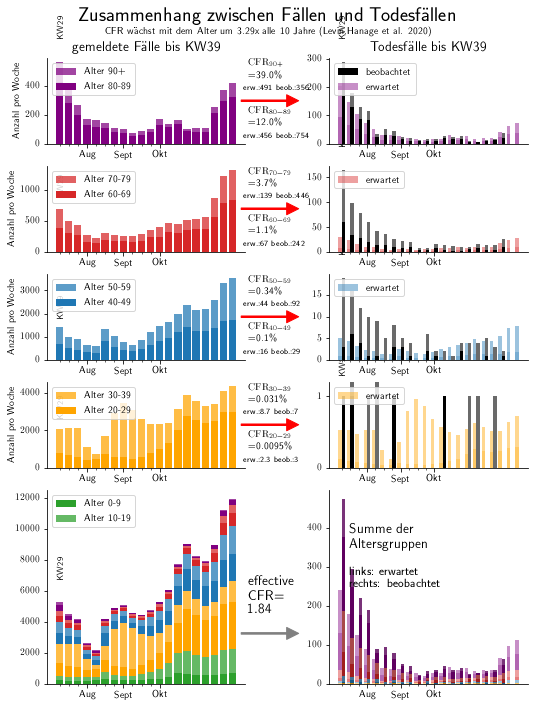

In [65]:
fig = plt.figure(figsize=(7.5,10))
fig.subplots_adjust(wspace=0.425,hspace=0.25,left=0.09,right=0.98,top=0.91,bottom=0.04)

plt.rc('text', usetex=True)

ts = pd.date_range(datetime.date(2020,2,1),periods=120,freq='D')
pts = pd.date_range(datetime.date(2020,2,1)+datetime.timedelta(days=30),periods=31,freq='D')

gs = fig.add_gridspec(6, 2)

#cfr = {"0-19":0.01,"20-39":0.0002,"40-59":0.002,"60-79":0.02,"80+":0.20}
age_groups = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90+"]
cfr,scfr = {},.12*np.sqrt(10.8)**2
for i,ag in enumerate(reversed(age_groups)):
    scfr/=np.sqrt(10.8)
    cfr[ag] = scfr

print(cfr)
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))

cx = fig.add_subplot(gs[4:,0])
dx = fig.add_subplot(gs[4:,1])
txs = [cx,dx]


l = len(cases_by_ab["80+"])
last_c = np.zeros(l)
last_cd = np.zeros(l)
last_d = np.zeros(l)

#last_c = cases["0-9"].copy()+cases["10-19"]
#last_d = deaths_by_ab["0-19"]

alpha2 = 0.73

for a,alpha in zip(["0-9","10-19"],[1,alpha2]):
    cx.bar(np.arange(len(cases[a])-3)+29,cases[a][2:-1],bottom=last_c[2:],width=.8,label="Alter "+a,color="tab:green",alpha=alpha)    
    last_c += cases[a][:-1]
    
color=["orange","tab:blue","tab:red","purple"]
for i,ab in enumerate([["20-29","30-39"],["40-49","50-59"],["60-69","70-79"],["80-89","90+"]]):
    a,b = ab
    print(i,a,b)
    ax = fig.add_subplot(gs[3-i,0])
    bx = fig.add_subplot(gs[3-i,1])
    txs += [ax,bx]
    
    c = color[i]
    for ag,alpha in zip([a,b],[1,alpha2]):
        cx.bar(np.arange(len(cases[ag])-3)+29,cases[ag][2:-1],bottom=last_c[2:],width=.8,color=c,alpha=alpha) 
        dx.bar(np.arange(len(cases[ag])-1)-.2+29,cases[ag][:-1]*cfr[ag],bottom=last_cd,width=.4,color=c,label="erwartet",alpha=.6*alpha)
        dx.bar(np.arange(len(deaths_by_age[ag])-2)+.2+29,deaths_by_age[ag][2:],bottom=last_d[2:],width=.4,color=c,label="beobachtet",alpha=alpha)
        
        last_c += cases[ag][:-1]
        last_cd += cases[ag][:-1]*cfr[ag]
        last_d += deaths_by_age[ag]
    
    ax.text(28.7,(cases[a][2]+cases[b][2])*1.3,"KW29",rotation=90,size=9)
    bx.text(28.7,max(deaths_by_age[a][2]+deaths_by_age[b][2],cases[a][0]*cfr[a]+cases[b][0]*cfr[b])*1.3,"KW29",rotation=90,size=9)
    
    ax.bar(np.arange(len(cases[b])-3)+29,cases[b][2:-1],bottom=cases[a][2:-1],width=.8,label="Alter "+b,color=c,alpha=alpha2)
    ax.bar(np.arange(len(cases[a])-3)+29,cases[a][2:-1],width=.8,label="Alter "+a,color=c)
  
    l = None
    if i == 3:
        l = "beobachtet"
    bx.bar(np.arange(len(deaths_by_age[a])-2)+.2+29,deaths_by_age[a][2:],width=.4,color="black",label=l)
    bx.bar(np.arange(len(deaths_by_age[b])-2)+.2+29,deaths_by_age[b][2:],bottom=deaths_by_age[a][2:],width=.4,color="black",alpha=alpha2*.8)
    
    bx.bar(np.arange(len(cases[b])-1)-.2+29,cases[b][:-1]*cfr[b],width=.4,bottom=cases[a][:-1]*cfr[a],color=c,alpha=alpha2*.6,label="erwartet")
    bx.bar(np.arange(len(cases[a])-1)-.2+29,cases[a][:-1]*cfr[a],width=.4,color=c,alpha=.6)  
           

    if i == 0:
        bx.set_ylim([0,1.2])
        bx.set_yticks([0,1])
        
    # calculate expected
    print("%s, %.1f %d"%(a,np.sum(cases[a][:-3])*cfr[a],np.sum(deaths_by_age[a][2:])))
    print("%s, %.1f %d"%(b,np.sum(cases[b][:-3])*cfr[b],np.sum(deaths_by_age[b][2:])))
    
    if True:
        erw_a = np.sum(cases[a][:-3])*cfr[a]
        erw_b = np.sum(cases[b][:-3])*cfr[b]

        ax.text(1.015,0.92,r"$\mathrm{CFR}_{%s}$"%(b),transform=ax.transAxes,rotation=0,size=10)
        ax.text(1.015,0.76,f"={round_to_n(cfr[b]*100,2)}\%",transform=ax.transAxes,rotation=0,size=10)
        if erw_b < 10:
            ax.text(.99,0.62,"erw.:%.1f beob.:%d"%(erw_b,np.sum(deaths_by_age[b][2:])),transform=ax.transAxes,size=8)
        else:
            ax.text(.99,0.62,"erw.:%d beob.:%d"%(erw_b,np.sum(deaths_by_age[b][2:])),transform=ax.transAxes,size=8)
    
        ax.text(1.015,0.37,r"$\mathrm{CFR}_{%s}$"%(a),transform=ax.transAxes,rotation=0,size=10)
        ax.text(1.015,0.21,f"={round_to_n(cfr[a]*100,2)}\%",transform=ax.transAxes,rotation=0,size=10)
        if erw_a < 10:
            ax.text(.99,0.07,"erw.:%.1f beob.:%d"%(erw_a,np.sum(deaths_by_age[a][2:])),transform=ax.transAxes,size=8)
        else:
            ax.text(.99,0.07,"erw.:%d beob.:%d"%(erw_a,np.sum(deaths_by_age[a][2:])),transform=ax.transAxes,size=8)


    ax.annotate("",xy=(1.27,.5),xytext=(.98,.5),xycoords='axes fraction', arrowprops=dict( color='red',width=1.5))
    ax.legend(loc="upper left")
    
    bx.legend(loc="upper left")
        
    if i == 3:
        ax.set_title("gemeldete Fälle bis KW39",size=14)
        bx.set_title("Todesfälle bis KW39",size=14)
    ax.set_ylabel("Anzahl pro Woche")
    
   # bx.set_ylim([0,80])
   # bx.set_yticks([0,25,50,75])

cx.legend()
dx.text(.1,.7,"Summe der\nAltersgruppen",transform=dx.transAxes,size=14)
dx.text(.1,.5,"links: erwartet\nrechts: beobachtet",transform=dx.transAxes,size=12)
fig.suptitle("Zusammenhang zwischen Fällen und Todesfällen",size=20)
#fig.text(0.5,.942,"CFR wächst alle 10 Jahre um %.2fx (Levin,Hanage et al. 2020)"%(np.sqrt(10.8)),ha="center",size=10)
fig.text(0.5,.942,"CFR wächst mit dem Alter um %.2fx alle 10 Jahre (Levin,Hanage et al. 2020)"%(np.sqrt(10.8)),ha="center",size=10)


#print(last_d[2:])
#print(last_c[:-2])

#s = "%.2f"%(100*np.mean(last_d[2:]/last_c[:-2]))
cx.text(1.015,0.36,f"effective\nCFR=\n~"+s+"%",transform=cx.transAxes,rotation=0,size=14)
cx.annotate("",xy=(1.27,.26),xytext=(.98,.26),xycoords='axes fraction', arrowprops=dict( color='grey',width=1.5))

cx.text(28.7,last_c[2]*1.3,"KW29",rotation=90,size=9)
dx.text(28.7,max(last_cd[2],last_d[2])*1.3,"KW29",rotation=90,size=9)

dx.bar(np.arange(len(deaths_by_age[ag])-2)+.2+29,last_d[2:],width=.4,color="black",label="beobachtet",alpha=0.25)

for tx in txs:
        
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        
    tx.set_xticks([32,36,40])
    tx.set_xticks(range(29,41),minor=True)
    tx.set_xticklabels(["Aug","Sept","Okt"])

    
fig.savefig("AgeCfrEstimatedDeathsStack_10y.pdf")
fig.savefig("AgeCfrEstimatedDeathsStack_10y.png",dpi=300)